<a href="https://colab.research.google.com/github/Camicb/MLOps-zoomcamp/blob/main/HW1_RideDuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup notebook

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# A seed for reproducibility
np.random.seed(2021)

# Load and explore data

In [3]:
# Load january data
jan = pd.read_parquet('/content/fhv_tripdata_2021-01.parquet')

#### Q1. Downloading the data
Read the data for January. How many records are there?

In [4]:
# Inspect data
jan.head()
jan.info()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


####Q2. Computing duration
What's the average trip duration in January?

In [5]:
jan['duration'] = ((jan['dropOff_datetime'] - jan['pickup_datetime']).dt.total_seconds())/60
avg_trip = (jan['duration']).mean()
avg_trip

19.1672240937939

#### Data preparation
Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [6]:
clean_jan = jan[(jan['duration']>=1) & (jan['duration']<=60)]
dropped_data = len(jan) - len(clean_jan)
dropped_data

44286

####Q3. Missing values
What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [7]:
# Get data for modeling
train = clean_jan[['PUlocationID', 'DOlocationID']]

# Impute  missing values
train.fillna(value=-1, inplace=True)

# Missing values for the pickup location ID
train['PUlocationID'].value_counts(normalize=True)*100

-1.0      83.527328
 221.0     0.750568
 206.0     0.612438
 129.0     0.484671
 115.0     0.367805
            ...    
 111.0     0.000451
 27.0      0.000360
 34.0      0.000270
 2.0       0.000180
 110.0     0.000090
Name: PUlocationID, Length: 262, dtype: float64

#### Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

In [8]:
# One-hot encoding
train = train.astype(str)
train_dicts = train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# Matrix dimension
X_train.shape


(1109826, 525)

# Modeling


#### Q5. Training a model

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

In [9]:
y_train = clean_jan['duration'].values

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_train = lr.predict(X_train)

LinearRegression()

In [10]:
# Metric
mean_squared_error(y_train, y_pred_train, squared=False)

10.528519107212679

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


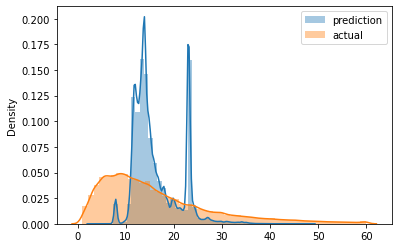

In [11]:
# Visualize results
%matplotlib inline

sns.distplot(y_pred_train, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


####Q6. Evaluating the model
Apply this model to the validation dataset (Feb 2021).

In [12]:
# Load and inspect february data --- TEST DATA
feb = pd.read_parquet('/content/fhv_tripdata_2021-02.parquet')

# Inspect data
feb.head()
feb.info()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00013,2021-02-01 00:01:00,2021-02-01 01:33:00,NaN,NaN,None,B00014
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,NaN,225.0,None,B00037


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037692 entries, 0 to 1037691
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1037692 non-null  object        
 1   pickup_datetime         1037692 non-null  datetime64[ns]
 2   dropOff_datetime        1037692 non-null  datetime64[ns]
 3   PUlocationID            153001 non-null   float64       
 4   DOlocationID            885340 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1037692 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 55.4+ MB


In [13]:
# Clean february data
feb['duration'] = ((feb['dropOff_datetime'] - feb['pickup_datetime']).dt.total_seconds())/60
clean_feb = feb[(feb['duration']>=1) & (feb['duration']<=60)]
test = clean_feb[['PUlocationID', 'DOlocationID']]
test.fillna(value=-1, inplace=True)

# Onde hot encoding
test = test.astype(str)
test_dicts = test.to_dict(orient='records')

X_test= dv.transform(test_dicts)
y_test = clean_feb['duration'].values

# Predictions
y_pred_test = lr.predict(X_test)

# Metric
print(mean_squared_error(y_test, y_pred_test, squared=False))

11.014283199431478
